<a href="https://colab.research.google.com/github/Yanikko/progetto-AI-2/blob/main/01_eda_HARTH.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HARTH — Exploratory Data Analysis (01_eda.ipynb)

Questo notebook:
- scarica il dataset **HARTH** da UCI
- ispeziona file/colonne disponibili
- fa una EDA di base (dimensioni, missing, distribuzione classi, per-soggetto)
- mostra esempi di segnali e correlazioni

> Nota: il dataset è grande (~300MB). La prima esecuzione può richiedere un po’ di tempo.


In [1]:
# (Opzionale) Se siete su Colab: abilita grafici più leggibili
import os, sys, textwrap, math, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 140)


## 1) Download e unpack del dataset

In [2]:
# Scarica HARTH da UCI (zip) e decomprime in ./data_raw/harth
# Se hai già scaricato in una run precedente, salta automaticamente.

from pathlib import Path
import subprocess

DATA_DIR = Path("data_raw/harth")
DATA_DIR.mkdir(parents=True, exist_ok=True)

zip_path = DATA_DIR / "harth.zip"
url = "https://archive.ics.uci.edu/static/public/779/harth.zip"

if not zip_path.exists():
    print("Downloading HARTH zip...")
    subprocess.run(["bash", "-lc", f"wget -O '{zip_path}' '{url}'"], check=True)
else:
    print("Zip already present:", zip_path)

# unzip (non sovrascrive se già estratto)
marker = DATA_DIR / ".unzipped"
if not marker.exists():
    print("Unzipping...")
    subprocess.run(["bash", "-lc", f"unzip -q '{zip_path}' -d '{DATA_DIR}'"], check=True)
    marker.write_text("ok")
else:
    print("Already unzipped.")

print("Done. Root:", DATA_DIR.resolve())


Unzipping...
Done. Root: /content/data_raw/harth


## 2) Esplora la struttura dei file

In [3]:
# Trova file tabellari (csv/tsv/txt) dentro la cartella
from pathlib import Path

tab_ext = {".csv", ".tsv", ".txt"}
all_files = [p for p in DATA_DIR.rglob("*") if p.is_file()]
tab_files = [p for p in all_files if p.suffix.lower() in tab_ext]

print(f"Totale file: {len(all_files)}")
print(f"File tabellari: {len(tab_files)}")
for p in tab_files[:20]:
    print("-", p.relative_to(DATA_DIR))


Totale file: 24
File tabellari: 22
- harth/S009.csv
- harth/S008.csv
- harth/S006.csv
- harth/S025.csv
- harth/S026.csv
- harth/S028.csv
- harth/S022.csv
- harth/S019.csv
- harth/S020.csv
- harth/S016.csv
- harth/S029.csv
- harth/S027.csv
- harth/S017.csv
- harth/S015.csv
- harth/S024.csv
- harth/S018.csv
- harth/S014.csv
- harth/S013.csv
- harth/S023.csv
- harth/S021.csv


## 3) Caricamento robusto (auto-detect separatore e colonne)

In [4]:
import pandas as pd

def read_table_auto(path: Path, nrows=None) -> pd.DataFrame:
    """Legge un file tabellare provando separatori comuni."""
    # Prova prima comma, poi tab/whitespace
    for sep in [",", "\t", ";"]:
        try:
            df = pd.read_csv(path, sep=sep, nrows=nrows)
            # euristica: deve avere almeno 2 colonne
            if df.shape[1] >= 2:
                return df
        except Exception:
            pass
    # fallback: whitespace
    return pd.read_csv(path, delim_whitespace=True, nrows=nrows)

# Carica un file di esempio per capire le colonne
if len(tab_files) == 0:
    raise RuntimeError("Non trovo file tabellari. Controlla il contenuto della zip.")
sample_path = tab_files[0]
df_sample = read_table_auto(sample_path, nrows=5)
print("Esempio file:", sample_path.relative_to(DATA_DIR))
display(df_sample)
print("Colonne:", list(df_sample.columns))


Esempio file: harth/S009.csv


,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label
0,2000-01-01 00:00:00.000,-0.988758,-0.144844,0.183325,-0.991851,-0.022659,-0.306466,6
1,2000-01-01 00:00:00.020,-1.008465,-0.137378,0.156743,-0.976224,-0.040058,-0.277258,6
2,2000-01-01 00:00:00.040,-0.991936,-0.143049,0.156618,-0.949758,-0.035796,-0.299548,6
3,2000-01-01 00:00:00.060,-1.007975,-0.140831,0.155302,-1.006806,-0.013057,-0.289020,6
4,2000-01-01 00:00:00.080,-0.991991,-0.159979,0.166965,-0.970159,0.015054,-0.293883,6


Colonne: ['timestamp', 'back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z', 'label']


## 4) Costruzione di un DataFrame unico (con colonne standard)

L’idea:
- concatenare più file (es. per soggetto/sessione) in un unico DF
- aggiungere una colonna `source_file` (utile per tracciare l’origine)
- provare a identificare automaticamente:
  - **label** (attività)
  - **subject** (id soggetto), se disponibile in colonna o nel nome file


In [12]:
import re

def infer_subject_from_filename(p: Path):
    # Cerca pattern tipo 'S01', 'subject01', 'sub_01', 'P01' ecc.
    m = re.search(r"(?:sub(?:ject)?|s|p)[_\- ]*(\d+)", p.stem, flags=re.IGNORECASE)
    return int(m.group(1)) if m else None

def pick_label_column(columns):
    # candidati comuni
    cand = ["label", "activity", "act", "class", "y"]
    lower = {c.lower(): c for c in columns}
    for k in cand:
        if k in lower:
            return lower[k]
    # fallback: ultima colonna se è categorica/pochi valori
    return None

def pick_subject_column(columns):
    cand = ["subject", "user", "participant", "person", "sub"]
    lower = {c.lower(): c for c in columns}
    for k in cand:
        if k in lower:
            return lower[k]
    return None

# Per non caricare subito tutto (dataset grande), iniziamo caricando N file
N_FILES = min(6, len(tab_files))   # aumenta se vuoi
dfs = []
for p in tab_files[:N_FILES]:
    df = read_table_auto(p)
    df["source_file"] = str(p.relative_to(DATA_DIR))
    # subject
    subj_col = pick_subject_column(df.columns)
    if subj_col is None:
        df["subject_inferred"] = infer_subject_from_filename(p)
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True)
print("Shape (subset):", df.shape)
display(df.head())


Shape (subset): (1574241, 10)


,timestamp,back_x,back_y,back_z,thigh_x,thigh_y,thigh_z,label,source_file,subject_inferred
0,2000-01-01 00:00:00.000,-0.988758,-0.144844,0.183325,-0.991851,-0.022659,-0.306466,6,harth/S009.csv,9
1,2000-01-01 00:00:00.020,-1.008465,-0.137378,0.156743,-0.976224,-0.040058,-0.277258,6,harth/S009.csv,9
2,2000-01-01 00:00:00.040,-0.991936,-0.143049,0.156618,-0.949758,-0.035796,-0.299548,6,harth/S009.csv,9
3,2000-01-01 00:00:00.060,-1.007975,-0.140831,0.155302,-1.006806,-0.013057,-0.289020,6,harth/S009.csv,9
4,2000-01-01 00:00:00.080,-0.991991,-0.159979,0.166965,-0.970159,0.015054,-0.293883,6,harth/S009.csv,9


## 5) Info base, missing values, tipi di dato

In [6]:
print(df.info())

missing = df.isna().mean().sort_values(ascending=False)
missing = missing[missing > 0]
print("\nMissing rate (solo >0):")
display(missing.to_frame("missing_rate"))

print("\nDescrittive (solo numeriche):")
display(df.describe(include=[np.number]).T.head(20))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1574241 entries, 0 to 1574240
Data columns (total 10 columns):
 #   Column            Non-Null Count    Dtype  
---  ------            --------------    -----  
 0   timestamp         1574241 non-null  object 
 1   back_x            1574241 non-null  float64
 2   back_y            1574241 non-null  float64
 3   back_z            1574241 non-null  float64
 4   thigh_x           1574241 non-null  float64
 5   thigh_y           1574241 non-null  float64
 6   thigh_z           1574241 non-null  float64
 7   label             1574241 non-null  int64  
 8   source_file       1574241 non-null  object 
 9   subject_inferred  1574241 non-null  int64  
dtypes: float64(6), int64(2), object(2)
memory usage: 120.1+ MB
None

Missing rate (solo >0):


,missing_rate



Descrittive (solo numeriche):


,count,mean,std,min,25%,50%,75%,max
back_x,1574241.0,-0.890857,0.295470,-5.766602,-0.999521,-0.940700,-0.757317,1.187988
back_y,1574241.0,-0.033763,0.176578,-3.100098,-0.120117,0.001953,0.066895,2.589111
back_z,1574241.0,-0.260278,0.407017,-4.011719,-0.592661,-0.278268,-0.023677,4.909483
thigh_x,1574241.0,-0.639780,0.653899,-8.000000,-1.010986,-0.640381,-0.046875,7.999756
thigh_y,1574241.0,0.012805,0.344421,-6.424316,-0.141606,0.023278,0.161919,7.948730
thigh_z,1574241.0,0.247039,0.779218,-8.000000,-0.274332,0.244385,0.964444,7.999756
label,1574241.0,10.261112,20.790393,1.000000,4.000000,7.000000,13.000000,140.000000
subject_inferred,1574241.0,14.411404,9.203843,6.000000,6.000000,8.000000,25.000000,28.000000


## 6) Distribuzione classi (se troviamo la colonna label)

Label column detected: label


,count
label,
7,561767
13,302882
1,291551
6,160942
3,54195
14,48048
2,45716
130,35930
8,34950


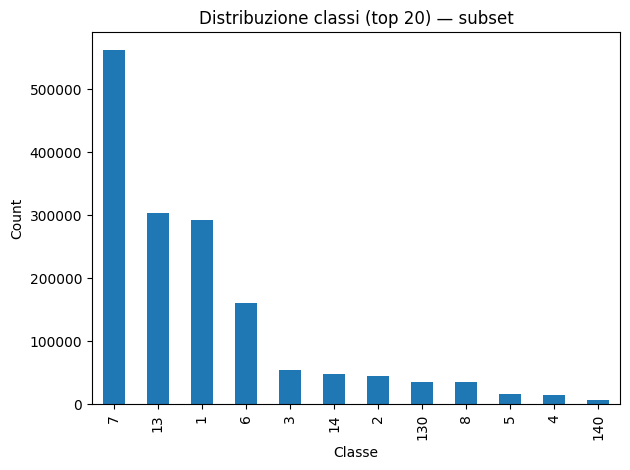

In [7]:
label_col = pick_label_column(df.columns)
print("Label column detected:", label_col)

if label_col is None:
    print("Non riesco a identificare automaticamente la colonna label in questo subset.")
else:
    vc = df[label_col].value_counts(dropna=False)
    display(vc.to_frame("count").head(30))

    plt.figure()
    vc.head(20).plot(kind="bar")
    plt.title("Distribuzione classi (top 20) — subset")
    plt.xlabel("Classe")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


## 7) Distribuzione per soggetto (se disponibile)

Subject column used: subject_inferred


,rows
subject_inferred,
8,418989
6,408709
25,231729
26,195172
28,165178
9,154464


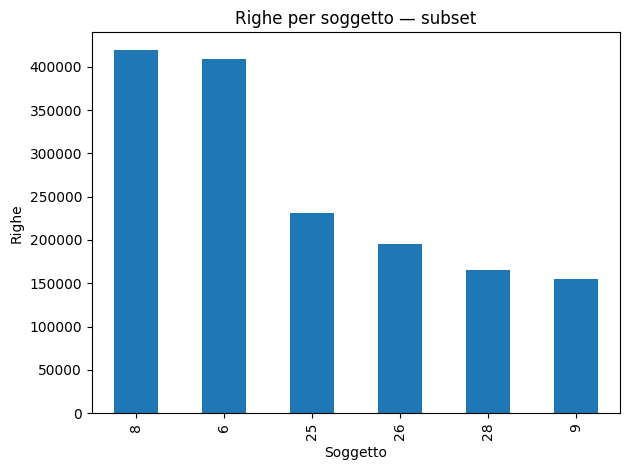

In [8]:
subj_col = pick_subject_column(df.columns)
if subj_col is not None:
    subj = df[subj_col]
elif "subject_inferred" in df.columns:
    subj = df["subject_inferred"]
else:
    subj = None

print("Subject column used:", subj_col if subj_col else ("subject_inferred" if subj is not None else None))

if subj is None:
    print("Non ho trovato informazioni sul soggetto in questo subset.")
else:
    vc_s = subj.value_counts(dropna=False)
    display(vc_s.to_frame("rows").head(30))
    plt.figure()
    vc_s.head(20).plot(kind="bar")
    plt.title("Righe per soggetto — subset")
    plt.xlabel("Soggetto")
    plt.ylabel("Righe")
    plt.tight_layout()
    plt.show()


## 8) Visualizzazione segnali (selezione automatica delle colonne sensore)

Cerchiamo colonne numeriche “tipo IMU” (es. `acc_x`, `acc_y`, `acc_z`...) e plottiamo
un piccolo segmento temporale, eventualmente filtrando per una classe.


Candidate signal columns: ['back_x', 'back_y', 'back_z', 'thigh_x', 'thigh_y', 'thigh_z'] 
Plotting class: 7


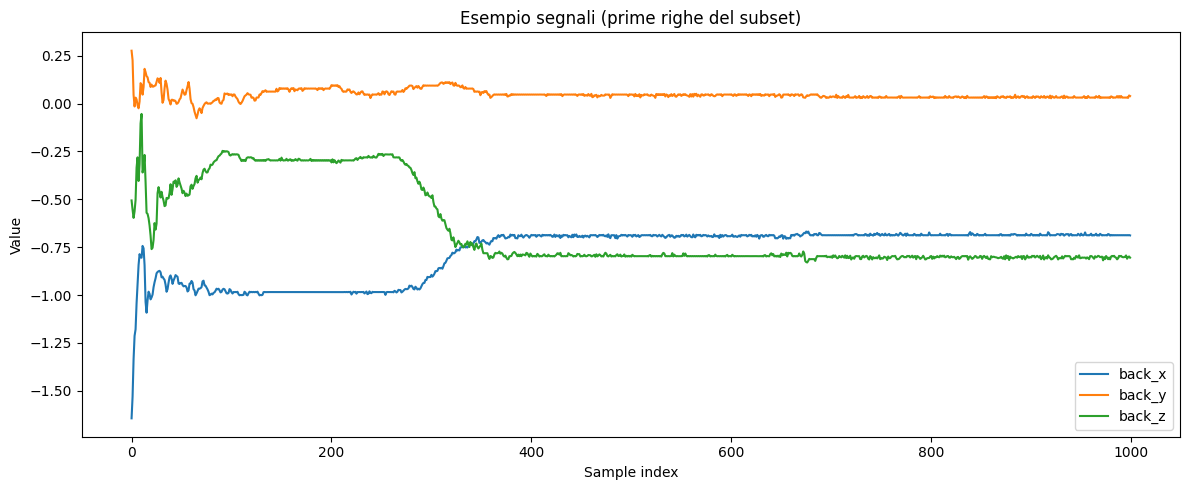

In [9]:
# Selezione colonne numeriche candidate a segnali (escludo label/subject)
num_cols = [c for c in df.columns if pd.api.types.is_numeric_dtype(df[c])]
exclude = set([c for c in [label_col, subj_col, "subject_inferred"] if c is not None] + ["source_file"])
signal_cols = [c for c in num_cols if c not in exclude]

print("Candidate signal columns:", signal_cols[:20], "..." if len(signal_cols) > 20 else "")

if len(signal_cols) == 0:
    print("Nessuna colonna numerica candidata trovata nel subset.")
else:
    # Se c'è una label, prendo una classe a caso tra le più frequenti
    df_plot = df.copy()
    if label_col is not None:
        top_class = df_plot[label_col].value_counts().index[0]
        df_plot = df_plot[df_plot[label_col] == top_class]
        print("Plotting class:", top_class)

    # Prendo un segmento di N punti
    N = min(1000, len(df_plot))
    seg = df_plot.iloc[:N]

    plt.figure(figsize=(12, 5))
    # plottiamo fino a 3 segnali per non affollare
    for c in signal_cols[:3]:
        plt.plot(seg[c].to_numpy(), label=c)
    plt.title("Esempio segnali (prime righe del subset)")
    plt.xlabel("Sample index")
    plt.ylabel("Value")
    plt.legend()
    plt.tight_layout()
    plt.show()


## 9) Correlazioni (subset)

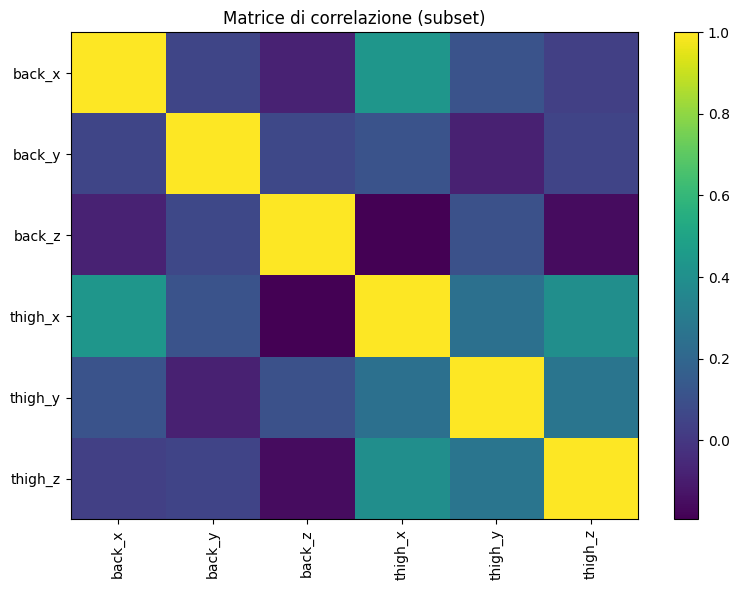

In [10]:
if len(signal_cols) >= 2:
    corr = df[signal_cols].corr(numeric_only=True)
    plt.figure(figsize=(8, 6))
    plt.imshow(corr, aspect="auto")
    plt.title("Matrice di correlazione (subset)")
    plt.xticks(range(len(signal_cols)), signal_cols, rotation=90)
    plt.yticks(range(len(signal_cols)), signal_cols)
    plt.colorbar()
    plt.tight_layout()
    plt.show()
else:
    print("Non abbastanza colonne numeriche per la correlazione.")


## 10) (Opzionale) Caricamento completo

Se volete fare EDA sull’intero dataset (più lento), impostate `LOAD_ALL=True`.


In [11]:
LOAD_ALL = False  # <-- metti True se vuoi concatenare tutti i file (più lento e RAM-heavy)

if LOAD_ALL:
    dfs = []
    for p in tab_files:
        try:
            dfi = read_table_auto(p)
            dfi["source_file"] = str(p.relative_to(DATA_DIR))
            subj_col = pick_subject_column(dfi.columns)
            if subj_col is None:
                dfi["subject_inferred"] = infer_subject_from_filename(p)
            dfs.append(dfi)
        except Exception as e:
            print("Skip", p, "err:", e)

    df_all = pd.concat(dfs, ignore_index=True)
    print("Shape (ALL):", df_all.shape)
    display(df_all.head())
